<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/4_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
!pip install shap
import shap
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

import keras
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten,TimeDistributed
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
# 데이터 불러오기
kospi_df = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/shift_kospi_sen_all.csv')
kospi_df = kospi_df.set_index('Date')

In [ ]:
kospi_df.shape

(588, 41)

- 최종 kospi_sentiment_score data

In [ ]:
kospi_senti_df = kospi_df.drop(columns = ['kofinbert_score_summarize_content_kospi','kofinbert_score_title_kospi','klue_bert_score_title'])
kospi_senti_df.head()

,research_kospi,Kospi_open,Kospi_high,Kospi_low,Kospi_close,Kospi_vol,dji_open,dji_high,dji_low,dji_close,...,gold_vol,oil_open,oil_high,oil_low,oil_close,oil_vol,ko_interest,ko_consumer,ko_real_estate,klue_bert_score_summarize_content
Date,,,,,,,,,,,,,,,,,,,,,
20210105,0.413,0.765,0.795,0.770,2990.57,0.232,0.632,0.638,0.647,0.648,...,0.417,0.213,0.214,0.225,0.220,0.013,0.0,0.137,0.911,-0.536
20210106,0.628,0.802,0.819,0.799,2968.21,0.388,0.641,0.667,0.657,0.672,...,0.408,0.219,0.218,0.230,0.222,0.006,0.0,0.137,0.911,1.381
20210107,0.427,0.830,0.839,0.820,3031.68,0.474,0.671,0.677,0.689,0.684,...,0.226,0.225,0.220,0.236,0.228,0.007,0.0,0.137,0.911,1.845
20210108,0.512,0.823,0.855,0.830,3152.18,0.389,0.681,0.674,0.683,0.687,...,0.336,0.230,0.231,0.242,0.239,0.004,0.0,0.137,0.911,2.497
20210111,0.881,0.855,0.914,0.862,3148.45,0.318,0.677,0.672,0.685,0.682,...,0.267,0.232,0.231,0.242,0.236,0.009,0.0,0.137,0.911,-0.951


# Removing Multicollinearity

In [ ]:
df = kospi_senti_df.copy()

In [ ]:
corr_values = df.corr()['Kospi_close'].drop(['Kospi_close'])
corr_values.abs().sort_values(ascending=False)

Kospi_high                           0.995413
Kospi_low                            0.995079
Kospi_open                           0.993841
ko_consumer                          0.918254
ex_AM_high                           0.917588
ex_AM_close                          0.915999
ex_AM_open                           0.915869
ex_AM_low                            0.915089
ko_interest                          0.877630
oil_open                             0.810001
oil_low                              0.807912
oil_high                             0.807666
oil_close                            0.805615
ex_JP_low                            0.803632
ex_JP_open                           0.795104
ex_JP_close                          0.794503
ex_JP_high                           0.785094
ko_real_estate                       0.746029
gold_low                             0.633372
gold_open                            0.629639
gold_close                           0.622317
gold_high                         

In [ ]:
sorted_columns = df.corr()['Kospi_close'].abs().sort_values(ascending=False).index
df = df[sorted_columns]

In [ ]:
del_list = ['Kospi_close']

# 상관행렬 계산
correlation_matrix = df.corr().abs()

# 상관계수가 0.9 이상인 변수들을 선택
high_corr_var = np.where(correlation_matrix > 0.9)

# (i, j) 인덱스 튜플의 리스트 생성
high_corr_var = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

for var_pair in high_corr_var:
  if var_pair[0] in del_list:
    pass
  else:
    try:
        df.drop(var_pair[1], axis=1, inplace=True)  # 두 번째 변수를 제거
    except KeyError as e:
        print(f"Error: {e}")
    del_list.append(var_pair[1])

In [ ]:
df.shape

(588, 14)

In [ ]:
# Create and fit the Random Forest model
X = df.drop('Kospi_close', axis=1)  # Dropping the target column to get the features
y = df['Kospi_close']  # Selecting the target column as labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tree-based Feature Importance

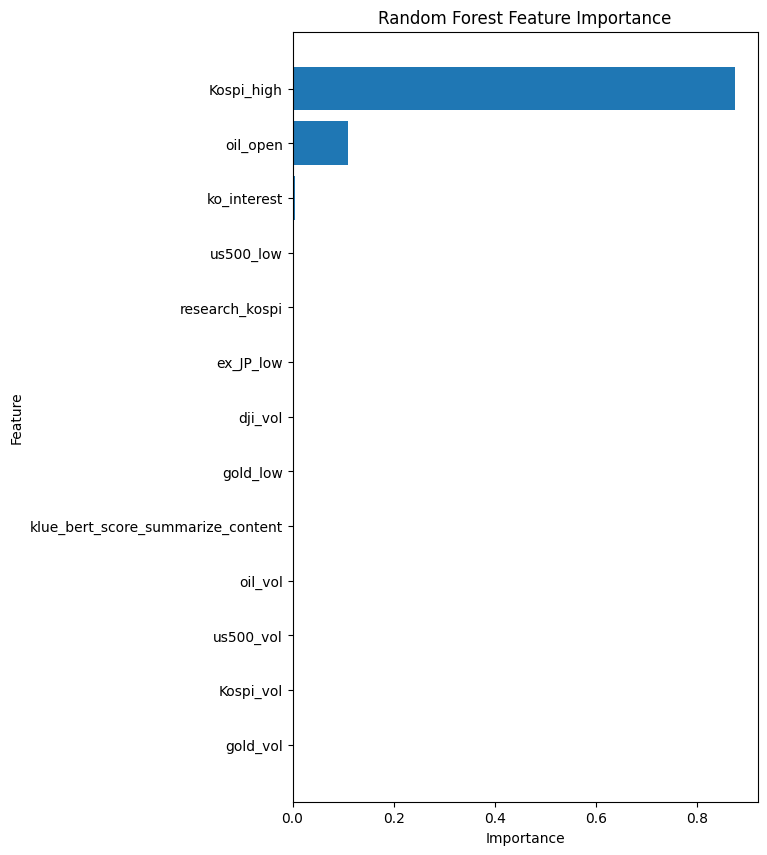

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances_rf = rf_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort indices by feature importances in ascending order
indices = feature_importances_rf.argsort()

# Rearrange feature names based on sorted indices
sorted_feature_names = [feature_names[i] for i in indices]

# Create a bar plot for feature importances
plt.figure(figsize=(6, 10))  # Swapped figsize to make it vertical
plt.barh(sorted_feature_names, feature_importances_rf[indices])  # Use barh for horizontal bar plot
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
feature_importance_rf = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': feature_importances_rf[indices]})

feature_importance_rf_df = feature_importance_rf.sort_values(by='Importance', ascending=False)
feature_importance_rf_df

,Feature,Importance
12,Kospi_high,0.874922
11,oil_open,0.110223
10,ko_interest,0.004312
9,us500_low,0.003572
8,research_kospi,0.001964
7,ex_JP_low,0.001257
6,dji_vol,0.000787
5,gold_low,0.000606
4,klue_bert_score_summarize_content,0.000558
3,oil_vol,0.000521


In [ ]:
del_col = list(feature_importance_rf_df['Feature'].values)[-2:]
df.drop(columns = del_col, inplace=True)

In [ ]:
# # 데이터 불러오기
# add = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/shift_kospi_sen_all.csv')
# add = add.set_index('Date')

# add = add[['kofinbert_score_summarize_content_kospi','kofinbert_score_title_kospi','klue_bert_score_title']]

# df = pd.concat([df, add], axis=1)

# df = df.reset_index()
# df.to_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/Final_Feature_kospi_sen_all.csv', index=False)

# Modeling

In [ ]:
# 데이터 전처리
data = df['Kospi_close'].values.reshape(-1, 1)
stock_data = df.drop(['Kospi_close'],axis=1)

In [ ]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t, test_data_t = stock_data[:train_size], stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t, train_data, look_back)
testX, testY = create_dataset(test_data_t,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

earlystopping = EarlyStopping(monitor='val_loss', patience=50)

(494, 5, 11)
(494, 1)
(84, 5, 11)
(84, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 1024)           3185664   
                                                                 
 dropout_6 (Dropout)         (None, 5, 1024)           0         
                                                                 
 gru_7 (GRU)                 (None, 5, 512)            2362368   
                                                                 
 dropout_7 (Dropout)         (None, 5, 512)            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 256)            591360    
                                                                 
 dropout_8 (Dropout)         (None, 5, 256)            0         
                                                                 
 gru_9 (GRU)                 (None, 5, 128)           

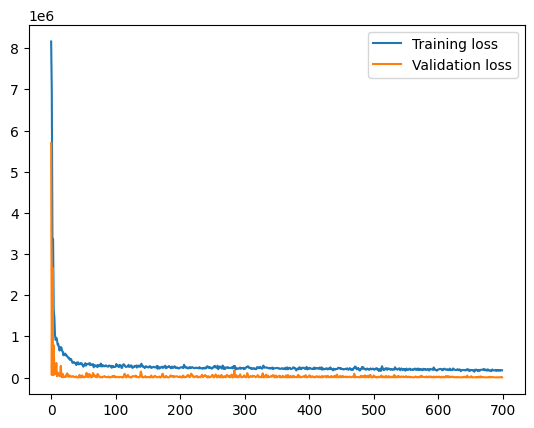

3/3 [==============================] - 0s 84ms/step
Training MSE: 5620.288051420524
Testing MSE: 4121.997399282369


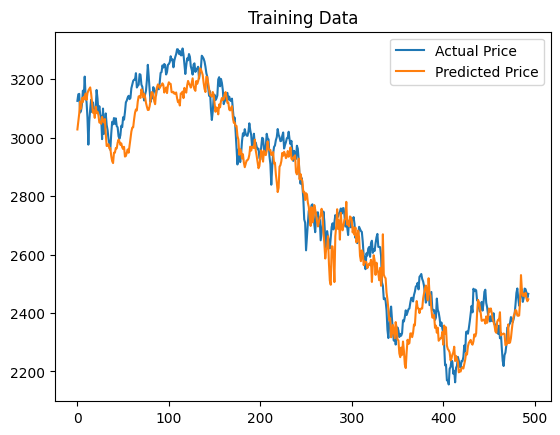

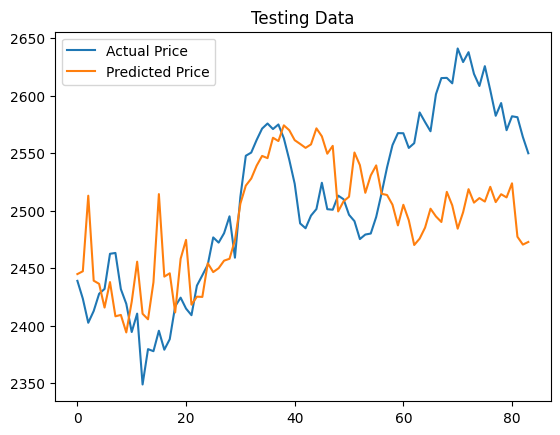

In [ ]:
# 모델 생성
model = Sequential()
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=700, batch_size=64,
          validation_split=0.1, verbose=2, callbacks=[checkpoint])

model.save_weights('./lstm_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()